### Dataset

- [Lamb et al. (2020): Global Whole Lithosphere Isostasy datasets](https://zenodo.org/record/4031646#.X822jXUzZH5)

  Model outputs from Lamb, S., Moore, J., Perez-Gussinye, M., Stern, T. (2020). Global whole lithosphere isostasy: implications for surface elevations, structure, strength and densities of the continental lithosphere, Geochem, Geophys, Geosyst., doi :10.1029/2020GC009150

- [EMC-CAM2016 (Global upper mantle surface wave tomography model)](http://ds.iris.edu/ds/products/emc-cam2016/)


### Reference:
- Lamb, S., Moore, J. D., Perez‐Gussinye, M., & Stern, T. Global whole lithosphere isostasy: implications for surface elevations, structure, strength and densities of the continental lithosphere. Geochemistry, Geophysics, Geosystems, e2020GC009150.
- Priestley, K., and D. McKenzie (2013), The relationship between shear wave velocity, temperature, attenuation and viscosity in the shallow part of the mantle, Earth and Planetary Science Letters, 381, 78–91. https://doi.org/10.1016/j.epsl.2013.08.022
- Priestley, K. , McKenzie, D. and Ho, T. (2019). A Lithosphere–Asthenosphere Boundary—a Global Model Derived from Multimode Surface‐Wave Tomography and Petrology. In Lithospheric Discontinuities (eds H. Yuan and B. Romanowicz). https://doi.org/10.1002/9781119249740.ch6

In [4]:
import numpy as np
import litho1pt0 as litho
import stripy
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
%matplotlib inline

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [5]:
# parameters for cartopy
rivers    = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m',
                                       edgecolor='Blue', facecolor="none")
coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '110m',
                                          edgecolor=(0.0,0.0,0.0),facecolor="none")
prj_base  = ccrs.PlateCarree()
#prj_base  = ccrs.Mercator()

# parameters for plot
xticks_global = np.arange(-180,180+10,60)
yticks_global = np.arange(-90,90+10,30)
xticks_area = np.arange(-180,180+5,5)
yticks_area = np.arange(-90,90+5,5)
dpi = 150
outputfile = "output_1_01_01/"
outputPath = os.path.join(os.path.abspath("."),outputfile) 
if not os.path.exists(outputPath):
    os.makedirs(outputPath)

### Whole lithosphere isostasy

The whole lithosphere isostasy is calculated by: 
$\Delta H = \Delta C/ \alpha - \Delta L /\beta$

Where, 

$\Delta H $ surface elevation above sea level

$\Delta C$ changes in crust thickness

$\Delta L$ changes in lithospheric thickness

$\alpha = \rho_a/(\rho_m-\rho_c)$

$\beta  = \rho_a/(\rho_m-\rho_a)$

In [9]:
# load conductive lithosphere thickness from Priestley2019
fname = "../Data/CAM2016/CAM2016Litho/CAM2016Litho"
data = np.loadtxt(fname)
lons,lats,z = data[:,1],data[:,0],data[:,2]
dlon,dlat = 2, 2

minlon,maxlon,minlat,maxlat = lons.min(),lons.max(),lats.min(),lats.max()
extent = (minlon,maxlon,minlat,maxlat)

nlon = int((maxlon-minlon)/dlon+1)
nlat = int((maxlat-minlat)/dlat+1)
size = nlon*nlat

lonv, latv = np.meshgrid(np.linspace(minlon,maxlon,nlon), np.linspace(minlat,maxlat,nlat), indexing='xy')

In [10]:
clt = np.zeros((nlat,nlon))
for i in range(size):
    lon_idx = int((lons[i]-minlon)/dlon)
    lat_idx = int((lats[i]-maxlat)/dlat)
    clt[lat_idx,lon_idx]=z[i]

/home/nl/anaconda3/envs/py37/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
/home/nl/anaconda3/envs/py37/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)
/home/nl/anaconda3/envs/py37/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not posit

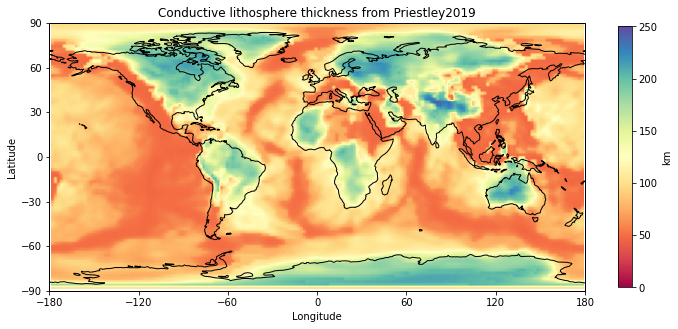

In [11]:
# Fig.3c in Lamb2020

data_img = clt
extent_img = extent 
fname_fig = "Conductive lithosphere thickness from Priestley2019"
cmap_img = cm.Spectral

fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax = plt.axes(projection=prj_base)
ax.set(xlabel='Longitude', ylabel='Latitude',xticks=xticks_global,yticks=yticks_global,title=fname_fig)
ax.set_global()
m=ax.imshow(data_img, origin='lower',cmap=cmap_img,vmin=0,vmax=250,extent=extent_img, transform=prj_base)
cbr = plt.colorbar(mappable=m,shrink=0.8) #, orientation='horizontal', shrink=0.8)
cbr.set_label("km")
ax.add_feature(coastline, linewidth=1.0, edgecolor="Black", zorder=5)
plt.savefig((outputPath+fname_fig+'.png'),dpi=dpi,bbox_inches='tight')

In [12]:
# load topo and crust thickness from litho1.0
l1 = litho.layer_depth(lat=latv, lon=lonv, layerID="WATER-BOTTOM")*0.001
l2 = litho.layer_depth(lat=latv, lon=lonv, layerID="CRUST1-TOP")*0.001
l3 = litho.layer_depth(lat=latv, lon=lonv, layerID="CRUST3-BOTTOM")*0.001

topo = -l1
cthickness = (l3 - l1) # include the topo
cthickness2 = (l3 - l2) # exclude the topo

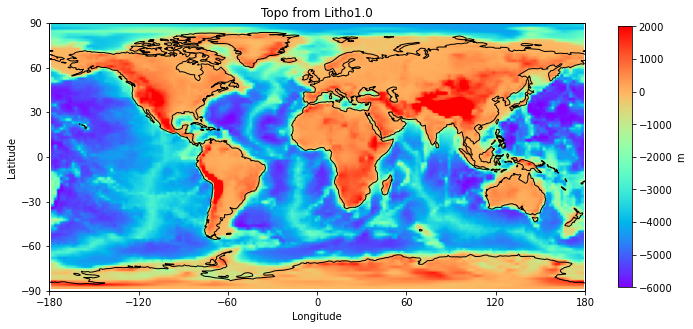

In [13]:
# Fig.2a in Lamb2020

data_img = topo*1000
extent_img = extent 
fname_fig = "Topo from Litho1.0"
cmap_img = cm.rainbow

fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax = plt.axes(projection=prj_base)
ax.set(xlabel='Longitude', ylabel='Latitude',xticks=xticks_global,yticks=yticks_global,title=fname_fig)
ax.set_global()
m=ax.imshow(data_img, origin='lower',cmap=cmap_img,vmin=-6000,vmax=2000,extent=extent_img, transform=prj_base)
cbr = plt.colorbar(mappable=m,shrink=0.8) #, orientation='horizontal', shrink=0.8)
cbr.set_label("m")
ax.add_feature(coastline, linewidth=1.0, edgecolor="Black", zorder=5)
plt.savefig((outputPath+fname_fig+'.png'),dpi=dpi,bbox_inches='tight')

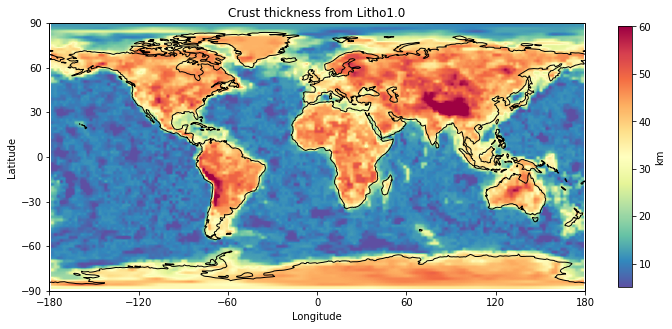

In [14]:
# Fig.2b in Lamb2020

data_img = cthickness
extent_img = extent 
fname_fig = "Crust thickness from Litho1.0"
cmap_img = cm.Spectral_r

fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax = plt.axes(projection=prj_base)
ax.set(xlabel='Longitude', ylabel='Latitude',xticks=xticks_global,yticks=yticks_global,title=fname_fig)
ax.set_global()
m=ax.imshow(data_img, origin='lower',cmap=cmap_img,vmin=5,vmax=60,extent=extent_img, transform=prj_base)
cbr = plt.colorbar(mappable=m,shrink=0.8) #, orientation='horizontal', shrink=0.8)
cbr.set_label("km")
ax.add_feature(coastline, linewidth=1.0, edgecolor="Black", zorder=5)
plt.savefig((outputPath+fname_fig+'.png'),dpi=dpi,bbox_inches='tight')

In [15]:
# # load crust type from litho1.0
# crust_type = np.empty_like(lonv, dtype=int)
# for i in range(0, lonv.shape[0]):
#     for j in range(0, lonv.shape[1]):
#         crust_type[i,j]= litho.crust_type_at(lon=lonv[i,j]+180, lat=latv[i,j])
# is_ocean = np.logical_and(crust_type <= 35,crust_type >= 25)
# is_orogen = np.logical_and(crust_type <= 19,crust_type >= 16)
# is_Antarctica = np.logical_or.reduce((crust_type ==2,crust_type ==6,crust_type ==14,crust_type ==21))
# is_normalocean =  crust_type == 25

In [16]:
is_ocean = topo<-1

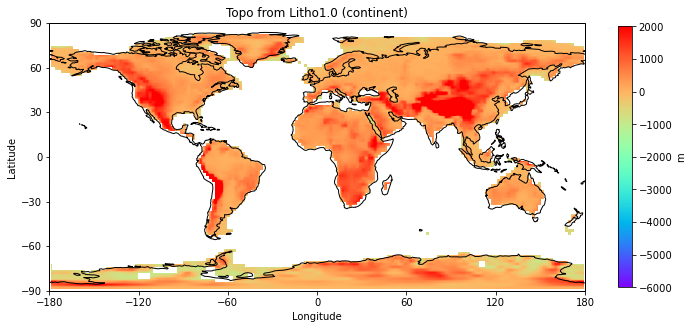

In [17]:
# Fig.2a in Lamb2020

data_img = topo*1000
data_img[is_ocean] = np.nan
extent_img = extent 
fname_fig = "Topo from Litho1.0 (continent)"
cmap_img = cm.rainbow

fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax = plt.axes(projection=prj_base)
ax.set(xlabel='Longitude', ylabel='Latitude',xticks=xticks_global,yticks=yticks_global,title=fname_fig)
ax.set_global()
m=ax.imshow(data_img, origin='lower',cmap=cmap_img,vmin=-6000,vmax=2000,extent=extent_img, transform=prj_base)
cbr = plt.colorbar(mappable=m,shrink=0.8) #, orientation='horizontal', shrink=0.8)
cbr.set_label("m")
ax.add_feature(coastline, linewidth=1.0, edgecolor="Black", zorder=5)
plt.savefig((outputPath+fname_fig+'.png'),dpi=dpi,bbox_inches='tight')

In [18]:
# cal the WLI (reference parameters from Lamb2020)
# 1 for continet, 2 for ocean
alpha1,beta1 = 7.8,93
alpha2,beta2 = 6.5,65
ref_c = 32
ref_l = 100

topo_cal1 = (cthickness-ref_c)/alpha1-(clt-ref_l)/beta1
topo_cal2 = (cthickness-ref_c)/alpha2-(clt-ref_l)/beta2

topo_cal = np.empty_like(topo_cal1)
topo_cal[~is_ocean] = topo_cal1[~is_ocean]
topo_cal[is_ocean]  = topo_cal2[is_ocean] 

dtopo = (topo-topo_cal)*1000

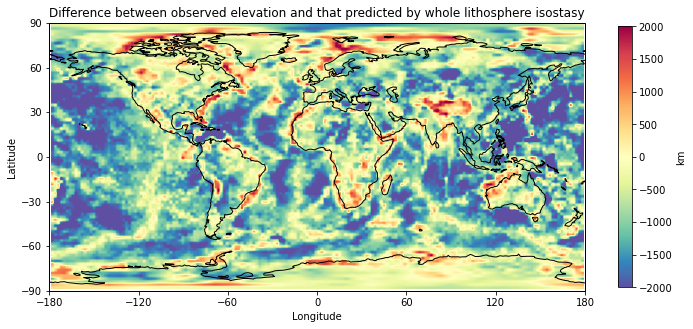

In [19]:
# Fig.8 in Lamb2020

data_img = dtopo
extent_img = extent 
fname_fig = "Difference between observed elevation and that predicted by whole lithosphere isostasy"
cmap_img = cm.Spectral_r
#cmap_img = plt.cm.get_cmap('RdYlBu_r')

fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax = plt.axes(projection=prj_base)
ax.set(xlabel='Longitude', ylabel='Latitude',xticks=xticks_global,yticks=yticks_global,title=fname_fig)
ax.set_global()
m=ax.imshow(data_img, origin='lower',cmap=cmap_img,vmin=-2000,vmax=2000,extent=extent_img, transform=prj_base)
cbr = plt.colorbar(mappable=m,shrink=0.8) #, orientation='horizontal', shrink=0.8)
cbr.set_label("km")
ax.add_feature(coastline, linewidth=1.0, edgecolor="Black", zorder=5)
plt.savefig((outputPath+fname_fig+'.png'),dpi=dpi,bbox_inches='tight')